### 1. Import relevant packges / functions:

In [1]:
# === Data Manipulation & Visualization ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# === Signal Processing ===
from scipy.signal import butter, filtfilt
from scipy.fftpack import fft
from scipy.stats import skew, kurtosis

# === Machine Learning Models ===
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# === Model Evaluation ===
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix,
    make_scorer
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_validate,
    KFold
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# === Deep Learning (TensorFlow/Keras) ===
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# === System/Utility ===
import os
from multiprocessing import cpu_count




### 2. Load raw data:

In [2]:
# Deinfe integer encoding for the 6 classes:
activity_to_code = {'dws': 1, 'ups': 2, 'sit': 3, 'std': 4, 'wlk': 5, 'jog': 6}
code_to_activity = {v:k for k,v in activity_to_code.items()}

In [3]:
# Change these three lines only
subject_data_file = r"C:\Users\maniq\Downloads\FYP\code\A_DeviceMotion_data\data_subjects_info.csv"
data_dir = r"C:\Users\maniq\Downloads\FYP\code\A_DeviceMotion_data"

os.chdir(data_dir)
os.chdir(os.pardir)

def get_all_dataset_paths(input_dir) -> []:
    """Retrieve all CSV file paths from the dataset directory, excluding metadata files."""
    input_files = []
    for dirs, subdirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.csv') and "data_subjects_info" not in file:  # Exclude metadata file
                input_files.append(os.path.join(dirs, file))
    return input_files

def load_whole_dataframe_from_paths(paths, meta) -> pd.DataFrame:
    """Load and merge all dataset CSVs into a single DataFrame with metadata."""
    
    df = pd.DataFrame()

    for p in paths:
        # Use os.path.split() to handle file paths correctly on Windows
        c_dir, c_file = os.path.split(p)
        c_dir = os.path.basename(c_dir)  # Extract the last directory name
        c_cat_ses = c_dir.split('_')[-2:]  # Extract category and session info

        # Ensure valid splitting
        if len(c_cat_ses) < 2:
            print(f"Skipping invalid directory format: {c_dir}")
            continue
        
        c_cat, c_ses = c_cat_ses
        try:
            c_sub = int(c_file.split('_')[-1].split('.')[-2])  # Convert subject ID to integer
        except ValueError:
            print(f"Skipping invalid subject file: {c_file}")
            continue  # Skip non-numeric subject files
        
        # Ensure subject ID exists in metadata
        if c_sub - 1 >= len(meta):
            print(f"Skipping invalid subject ID: {c_sub}")
            continue
        
        # Load data and add metadata
        tdf = pd.read_csv(p, encoding="utf-8")
        tdf = tdf.assign(subject_id=c_sub)
        tdf = tdf.assign(session_id=int(c_ses))
        tdf = tdf.assign(category=str(c_cat))
        tdf = tdf.assign(age=int(meta.loc[c_sub - 1, "age"]))
        tdf = tdf.assign(gender=int(meta.loc[c_sub - 1, "gender"]))
        tdf = tdf.assign(height=int(meta.loc[c_sub - 1, "height"]))
        tdf = tdf.assign(weight=int(meta.loc[c_sub - 1, "weight"]))

        df = pd.concat([df, tdf], ignore_index=True)
    
    return df

# Load subject metadata
subject_data_frame = pd.read_csv(subject_data_file, encoding="utf-8")

# Retrieve all dataset paths
all_dataset_paths = get_all_dataset_paths(data_dir)

# Load the full dataset into a DataFrame
data_frame = load_whole_dataframe_from_paths(all_dataset_paths, subject_data_frame)

# Display the first few rows of the final dataset
(data_frame.head())



Skipping invalid subject file: data_x_x2_x3.csv
Skipping invalid subject file: msft.csv
Skipping invalid subject file: Stocks.csv
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory format: data
Skipping invalid directory for

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,subject_id,session_id,category,age,gender,height,weight
0,0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,1,1,dws,46,1,188,102
1,1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,1,1,dws,46,1,188,102
2,2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,1,1,dws,46,1,188,102
3,3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,1,1,dws,46,1,188,102
4,4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,1,1,dws,46,1,188,102


## Exploratory Data Analysis

### Show Dataframe Characteristic

In [4]:
data_frame


,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,subject_id,session_id,category,age,gender,height,weight
0,0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,1,1,dws,46,1,188,102
1,1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,1,1,dws,46,1,188,102
2,2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,1,1,dws,46,1,188,102
3,3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,1,1,dws,46,1,188,102
4,4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,1,1,dws,46,1,188,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1412860,4749,0.890518,-1.300928,0.089878,0.207249,0.963806,-0.167690,-0.920226,0.406762,-0.383194,0.044079,-0.204574,0.204906,9,8,wlk,32,1,190,93
1412861,4750,0.929499,-1.319499,0.124063,0.199247,0.968591,-0.148750,-0.923594,0.231559,-0.521862,0.066348,-0.222604,0.225136,9,8,wlk,32,1,190,93
1412862,4751,0.966103,-1.340284,0.159858,0.187951,0.973550,-0.129883,-0.970054,0.003083,-0.621238,-0.005959,-0.054040,0.240632,9,8,wlk,32,1,190,93
1412863,4752,1.005158,-1.362495,0.201540,0.174576,0.978384,-0.110827,-1.005371,-0.108297,-0.708937,-0.007767,-0.003927,0.194735,9,8,wlk,32,1,190,93


### DataFrame shape

In [5]:
print("raw data shape: ", data_frame.shape)
print("\nraw data columns:\n", data_frame.columns)


raw data shape:  (1412865, 20)

raw data columns:
 Index(['Unnamed: 0', 'attitude.roll', 'attitude.pitch', 'attitude.yaw',
       'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x',
       'rotationRate.y', 'rotationRate.z', 'userAcceleration.x',
       'userAcceleration.y', 'userAcceleration.z', 'subject_id', 'session_id',
       'category', 'age', 'gender', 'height', 'weight'],
      dtype='object')


In [6]:
print(data_frame.dtypes)


Unnamed: 0              int64
attitude.roll         float64
attitude.pitch        float64
attitude.yaw          float64
gravity.x             float64
gravity.y             float64
gravity.z             float64
rotationRate.x        float64
rotationRate.y        float64
rotationRate.z        float64
userAcceleration.x    float64
userAcceleration.y    float64
userAcceleration.z    float64
subject_id              int64
session_id              int64
category               object
age                     int64
gender                  int64
height                  int64
weight                  int64
dtype: object


### Overview about Unique Values

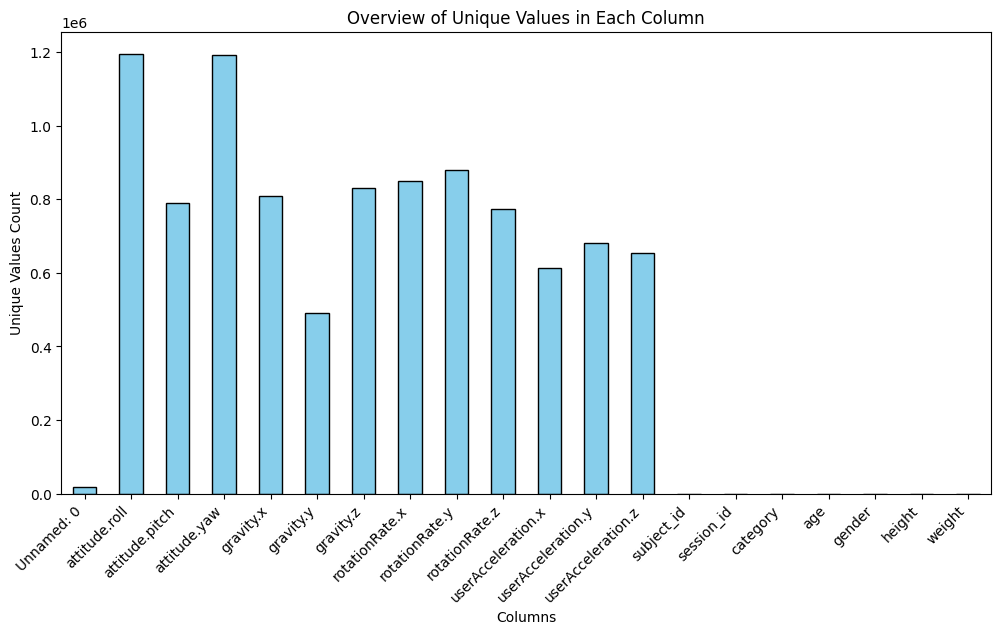

In [7]:
# Count the number of unique values in each column
column_counts = data_frame.nunique()

# Plot the bar chart
plt.figure(figsize=(12, 6))
column_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel("Columns")
plt.ylabel("Unique Values Count")
plt.title("Overview of Unique Values in Each Column")
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


### Check Null Value In Each Column

In [8]:
print(data_frame.isnull().sum())


Unnamed: 0            0
attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
subject_id            0
session_id            0
category              0
age                   0
gender                0
height                0
weight                0
dtype: int64


### Check Duplicate Rows

In [9]:
# Check total number of duplicate rows
duplicate_rows = data_frame.duplicated()
print("Total duplicate rows:", duplicate_rows.sum())



Total duplicate rows: 0


### Summary Statistics for Motion Sensor Data


In [10]:
MOTION_SENSOR_COLUMNS = ['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 
                         'rotationRate.x', 'rotationRate.y', 'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y',
                        'userAcceleration.z']
DEMOGRAPHIC_FEATURES = ['weight', 'height', 'age', 'gender']

In [11]:
data_frame[MOTION_SENSOR_COLUMNS].describe(percentiles=[0.001,0.01,0.25,0.5,0.75,0.95,0.99, 0.999]).round(3)


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
count,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000,1412865.000
mean,-0.176,-0.987,-0.149,0.042,0.755,-0.139,0.005,0.015,0.013,-0.004,0.044,0.039
std,1.567,0.494,1.545,0.339,0.333,0.428,1.293,1.226,0.808,0.328,0.528,0.376
min,-3.142,-1.570,-3.142,-1.000,-1.000,-1.000,-17.366,-18.414,-12.151,-6.369,-5.674,-7.743
0.1%,-3.129,-1.557,-3.132,-0.986,-0.997,-1.000,-5.761,-6.713,-4.501,-2.009,-2.137,-2.361
1%,-3.044,-1.533,-3.030,-0.782,-0.117,-0.998,-3.596,-3.624,-2.539,-1.050,-1.323,-1.111
25%,-1.480,-1.358,-1.278,-0.173,0.584,-0.392,-0.286,-0.167,-0.097,-0.048,-0.062,-0.024
50%,0.122,-1.181,-0.136,0.020,0.925,-0.097,-0.000,0.000,0.000,0.001,0.004,0.003
75%,0.876,-0.623,0.829,0.272,0.978,0.085,0.116,0.231,0.113,0.044,0.052,0.105
95%,2.372,-0.092,2.674,0.605,0.997,0.720,2.406,1.953,1.313,0.467,0.871,0.638


### Plotting each of the column

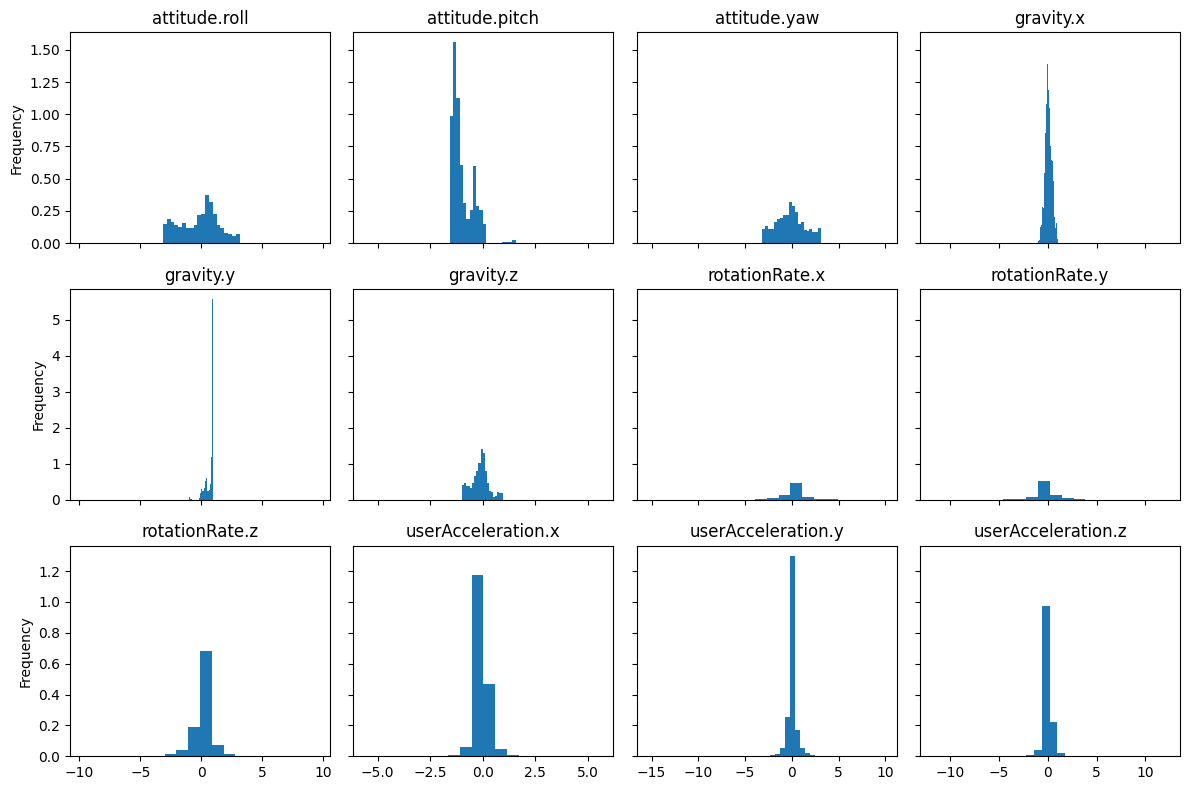

In [12]:
# Sample for faster plotting
samp = data_frame.sample(10**5)  # Sample 100,000 rows

# Plot histograms
fig, ax = plt.subplots(3, 4, sharex='col', sharey='row', figsize=(12, 8))

m = 0
for i in range(3):
    for j in range(4):
        colname = MOTION_SENSOR_COLUMNS[m]
        samp[colname].plot(kind='hist', ax=ax[i, j], bins=20, density=True, title=colname)
        m += 1

plt.tight_layout()
plt.show()


In [13]:
data_frame[['weight','height','age']].describe().round(2)


,weight,height,age
count,1412865.00,1412865.00,1412865.00
mean,72.12,173.99,28.83
std,15.98,8.80,5.30
min,48.00,161.00,18.00
25%,60.00,164.00,25.00
50%,72.00,175.00,28.00
75%,78.00,180.00,31.00
max,102.00,190.00,46.00


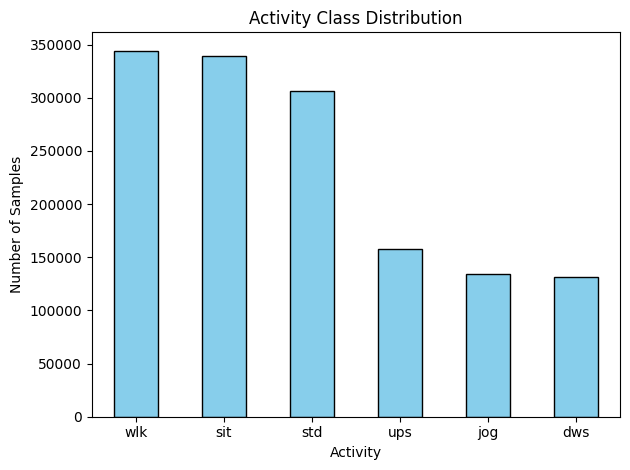

In [14]:
# Count each activity
activity_counts = data_frame['category'].value_counts()

# Plot
activity_counts.plot(kind='bar', title='Activity Class Distribution', color='skyblue', edgecolor='black')
plt.ylabel("Number of Samples")
plt.xlabel("Activity")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Data Preprocessing

###  Low-Pass Butterworth Filter Implementation (Using SciPy)



--- userAcceleration.x ---
Row 1 | Original: 0.2949 | Filtered: 0.2875
Row 2 | Original: 0.2194 | Filtered: 0.2440
Row 3 | Original: 0.0107 | Filtered: 0.2042
Row 4 | Original: -0.0084 | Filtered: 0.1692
Row 5 | Original: 0.1994 | Filtered: 0.1397


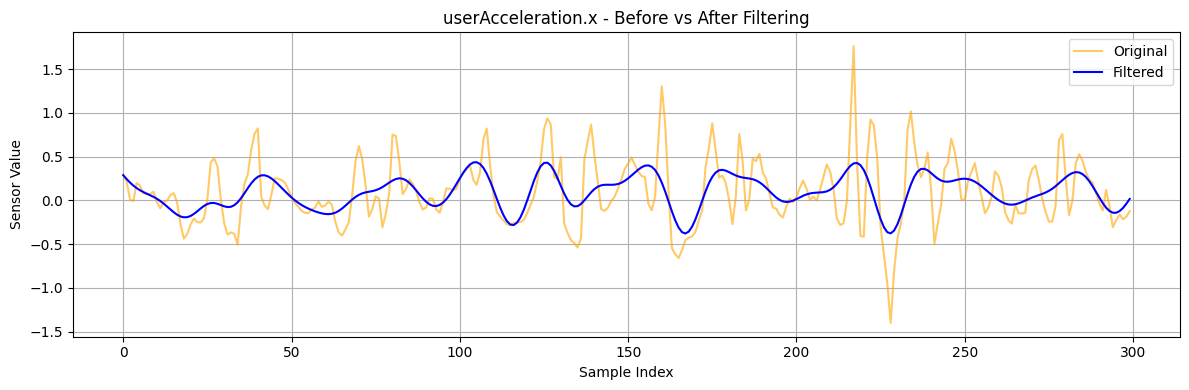


--- userAcceleration.y ---
Row 1 | Original: -0.1845 | Filtered: -0.1865
Row 2 | Original: 0.0358 | Filtered: -0.1138
Row 3 | Original: 0.1347 | Filtered: -0.0471
Row 4 | Original: 0.1368 | Filtered: 0.0086
Row 5 | Original: 0.3540 | Filtered: 0.0497


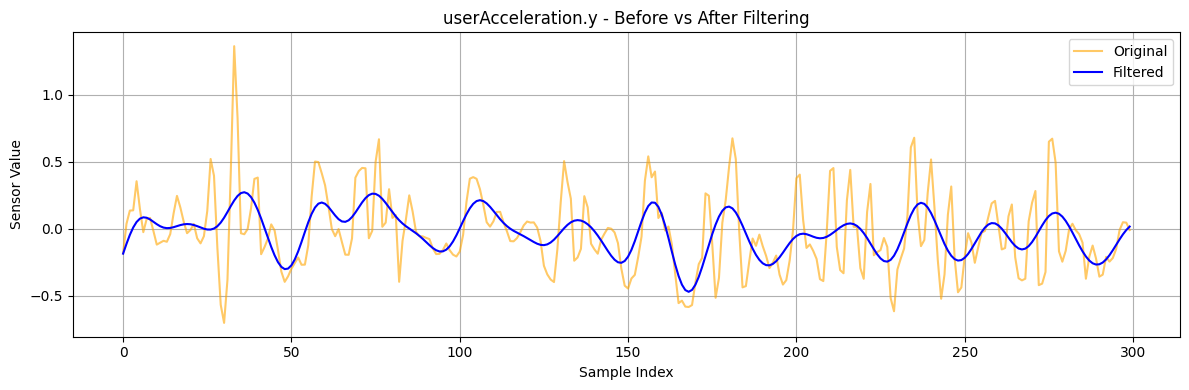


--- userAcceleration.z ---
Row 1 | Original: 0.3775 | Filtered: 0.3796
Row 2 | Original: 0.1149 | Filtered: 0.2604
Row 3 | Original: -0.1678 | Filtered: 0.1458
Row 4 | Original: 0.0950 | Filtered: 0.0419
Row 5 | Original: -0.0443 | Filtered: -0.0461


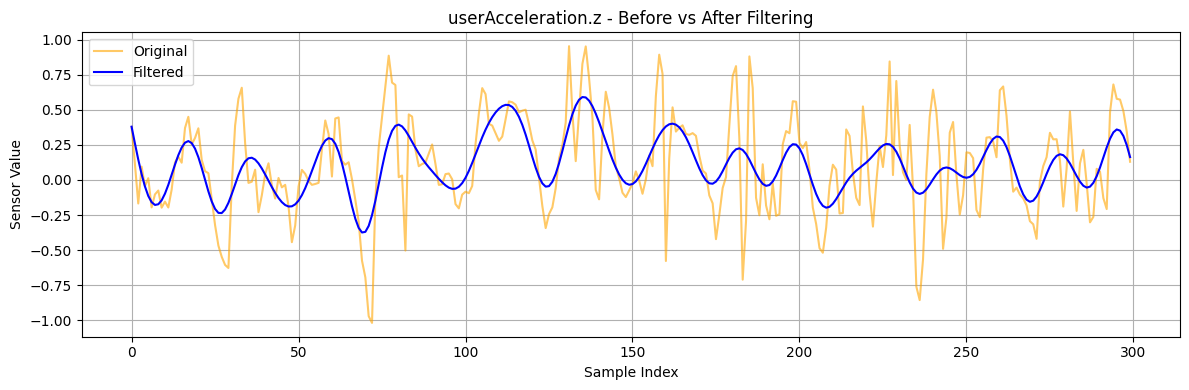


--- rotationRate.x ---
Row 1 | Original: 0.3167 | Filtered: 0.2687
Row 2 | Original: 0.8420 | Filtered: 0.2133
Row 3 | Original: -0.1381 | Filtered: 0.1746
Row 4 | Original: -0.0250 | Filtered: 0.1628
Row 5 | Original: 0.1143 | Filtered: 0.1854


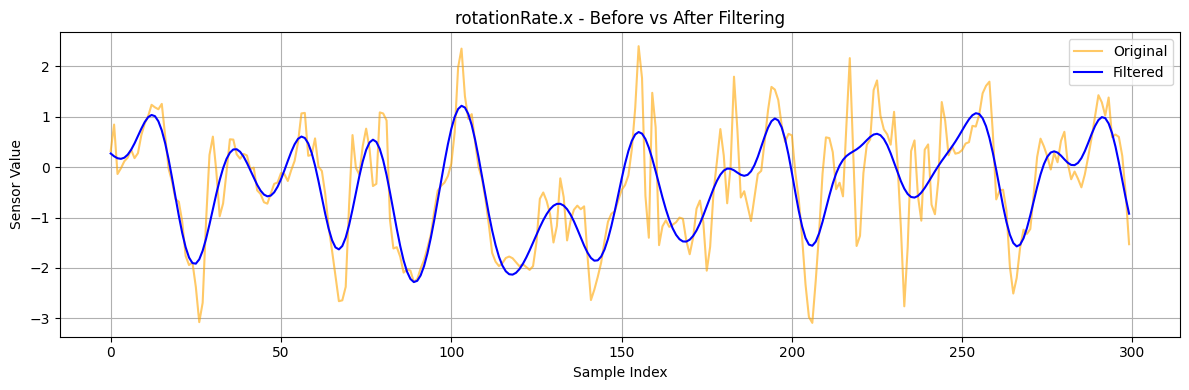


--- rotationRate.y ---
Row 1 | Original: 0.7782 | Filtered: 0.8620
Row 2 | Original: 0.4244 | Filtered: 0.6839
Row 3 | Original: -0.0407 | Filtered: 0.5027
Row 4 | Original: -1.0487 | Filtered: 0.3192
Row 5 | Original: -0.9129 | Filtered: 0.1306


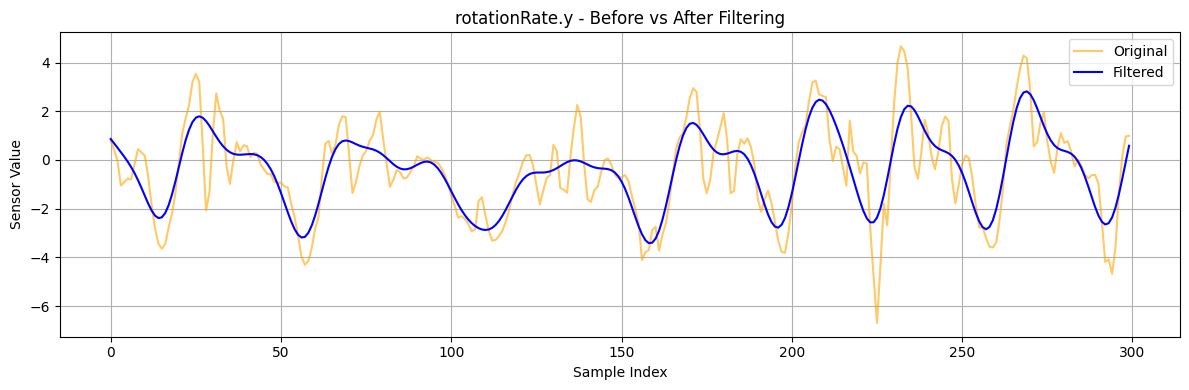


--- rotationRate.z ---
Row 1 | Original: 1.0828 | Filtered: 1.0582
Row 2 | Original: 0.6436 | Filtered: 0.8142
Row 3 | Original: 0.3436 | Filtered: 0.5863
Row 4 | Original: 0.0359 | Filtered: 0.3862
Row 5 | Original: 0.0473 | Filtered: 0.2231


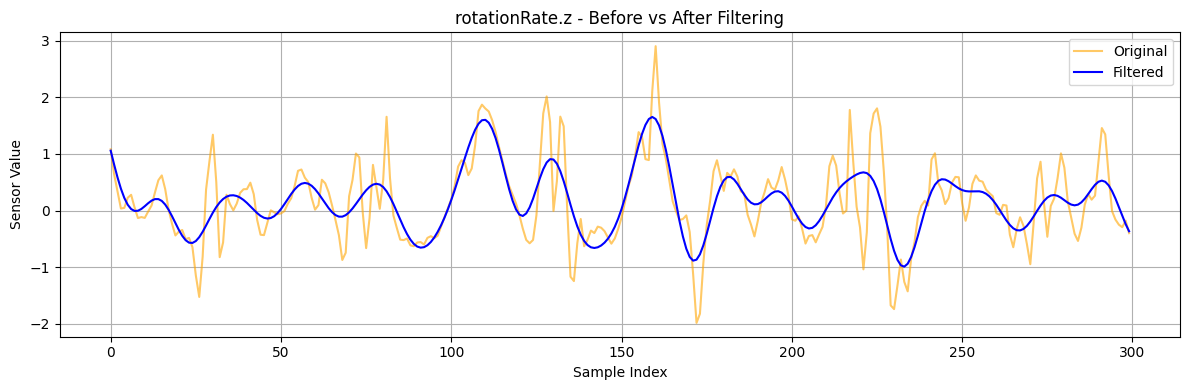

In [15]:
# Butterworth low-pass filter function
def butter_lowpass_filter(data, cutoff=3.0, fs=50.0, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Define sensor columns to filter
sensor_columns = [
    'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z',
    'rotationRate.x', 'rotationRate.y', 'rotationRate.z'
]

# Apply filter and compare
for col in sensor_columns:
    if col in data_frame.columns:
        # Apply filter
        filtered_data = butter_lowpass_filter(data_frame[col])
        data_frame[f'{col}_filtered'] = filtered_data

        # Print original vs filtered (first 5 rows)
        print(f"\n--- {col} ---")
        for i in range(5):
            orig = data_frame[col].iloc[i]
            filt = data_frame[f'{col}_filtered'].iloc[i]
            print(f"Row {i+1} | Original: {orig:.4f} | Filtered: {filt:.4f}")

        # Plot comparison
        plt.figure(figsize=(12, 4))
        plt.plot(data_frame[col].values[:300], label='Original', alpha=0.6, color='orange')
        plt.plot(filtered_data[:300], label='Filtered', color='blue')
        plt.title(f"{col} - Before vs After Filtering")
        plt.xlabel("Sample Index")
        plt.ylabel("Sensor Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### Data Segmentation

In [16]:
import numpy as np
import pandas as pd

#  Parameters 
window_size = 128      # 2.56 seconds @ 50 Hz
step_size = 64         # 50% overlap
sensor_cols = [
    'userAcceleration.x_filtered', 'userAcceleration.y_filtered', 'userAcceleration.z_filtered',
    'rotationRate.x_filtered', 'rotationRate.y_filtered', 'rotationRate.z_filtered',
    'gravity.x', 'gravity.y', 'gravity.z',
    'attitude.roll', 'attitude.pitch', 'attitude.yaw'
]  # Adjust to match your filtered column names

#  Containers 
ml_features = []
dl_windows = []
dl_labels = []

# Segment by subject & activity 
for (subject_id, activity), group in data_frame.groupby(['subject_id', 'category']):
    group = group.sort_values('Unnamed: 0')  # sort by time
    data = group[sensor_cols].values
    n_samples = len(data)

    for start in range(0, n_samples - window_size + 1, step_size):
        window = data[start:start + window_size]
        
        # === For ML: extract statistical features ===
        feature_row = {
            'subject_id': subject_id,
            'activity': activity
        }
        for i, col in enumerate(sensor_cols):
            signal = window[:, i]
            feature_row[f'{col}_mean'] = signal.mean()
            feature_row[f'{col}_std'] = signal.std()
            feature_row[f'{col}_min'] = signal.min()
            feature_row[f'{col}_max'] = signal.max()
            feature_row[f'{col}_median'] = np.median(signal)
        ml_features.append(feature_row)

        #  For DL: store raw window 
        dl_windows.append(window)
        dl_labels.append(activity)

#  Final Outputs 
ml_df = pd.DataFrame(ml_features)  # For ML models
X_dl = np.array(dl_windows)        # shape = (num_windows, 128, num_features)
y_dl = np.array(dl_labels)         # activity labels for DL


### Check Datashape after Segmentation


In [17]:
print(" ML Feature Dataset shape:", ml_df.shape)
print(" DL Windows shape:", X_dl.shape)
print(" DL Labels shape:", y_dl.shape)

# preview 1 row of ML features
print("\nSample ML feature row:")
print(ml_df.iloc[0])


 ML Feature Dataset shape: (21864, 62)
 DL Windows shape: (21864, 128, 12)
 DL Labels shape: (21864,)

Sample ML feature row:
subject_id                                 1
activity                                 dws
userAcceleration.x_filtered_mean    0.041432
userAcceleration.x_filtered_std     0.133928
userAcceleration.x_filtered_min    -0.193428
                                      ...   
attitude.yaw_mean                   0.431761
attitude.yaw_std                     0.73838
attitude.yaw_min                   -0.900628
attitude.yaw_max                    1.652762
attitude.yaw_median                 0.608294
Name: 0, Length: 62, dtype: object


### Activity Class Distribution after Segmentation

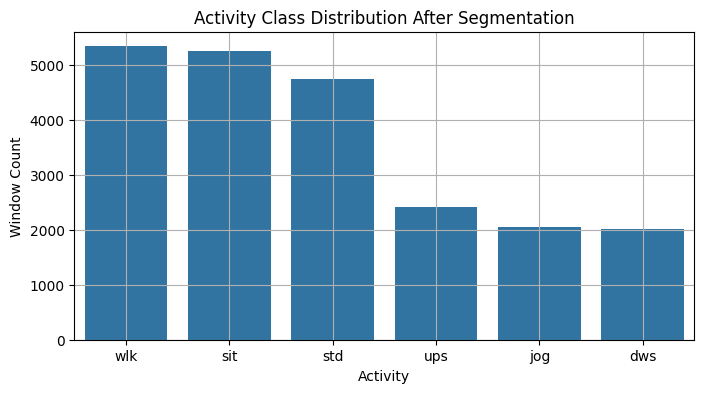

In [18]:
plt.figure(figsize=(8, 4))
sns.countplot(x=y_dl, order=pd.Series(y_dl).value_counts().index)
plt.title("Activity Class Distribution After Segmentation")
plt.xlabel("Activity")
plt.ylabel("Window Count")
plt.grid(True)
plt.show()


### Feature Extraction


### Sliding Window Feature Extraction (Time + Frequency Domain)

In [19]:
# Parameters 
window_size = 128      # 2.56 seconds @ 50Hz
step_size = 64         # 50% overlap
sensor_cols = [
    'userAcceleration.x_filtered', 'userAcceleration.y_filtered', 'userAcceleration.z_filtered',
    'rotationRate.x_filtered', 'rotationRate.y_filtered', 'rotationRate.z_filtered'
]  # Adjust this if you use different column names

feature_rows = []

# Sliding Window Segmentation with Feature Extraction 
for (subject_id, activity), group in data_frame.groupby(['subject_id', 'category']):
    group = group.sort_values('Unnamed: 0')
    data = group[sensor_cols].values
    n_samples = len(data)

    for start in range(0, n_samples - window_size + 1, step_size):
        window = data[start:start + window_size]
        feature_row = {
            'subject_id': subject_id,
            'activity': activity
        }

        for i, col in enumerate(sensor_cols):
            signal = window[:, i]

            #  Time-domain features 
            feature_row[f'{col}_mean'] = np.mean(signal)
            feature_row[f'{col}_std'] = np.std(signal)
            feature_row[f'{col}_min'] = np.min(signal)
            feature_row[f'{col}_max'] = np.max(signal)
            feature_row[f'{col}_range'] = np.max(signal) - np.min(signal)
            feature_row[f'{col}_skew'] = skew(signal)
            feature_row[f'{col}_kurtosis'] = kurtosis(signal)

            # Frequency-domain features using FFT 
            fft_signal = np.abs(fft(signal))
            fft_signal = fft_signal[:len(fft_signal) // 2]  # keep positive frequencies

            feature_row[f'{col}_fft_amplitude'] = np.mean(fft_signal)
            feature_row[f'{col}_fft_energy'] = np.sum(fft_signal ** 2) / len(fft_signal)
            feature_row[f'{col}_fft_dc'] = fft_signal[0]
            feature_row[f'{col}_fft_skew'] = skew(fft_signal)
            feature_row[f'{col}_fft_kurtosis'] = kurtosis(fft_signal)

        feature_rows.append(feature_row)

# Output 
feature_df = pd.DataFrame(feature_rows)
print(" Feature DataFrame shape:", feature_df.shape)
(feature_df.head(2))


 Feature DataFrame shape: (21864, 74)


,subject_id,activity,userAcceleration.x_filtered_mean,userAcceleration.x_filtered_std,userAcceleration.x_filtered_min,userAcceleration.x_filtered_max,userAcceleration.x_filtered_range,userAcceleration.x_filtered_skew,userAcceleration.x_filtered_kurtosis,userAcceleration.x_filtered_fft_amplitude,...,rotationRate.z_filtered_min,rotationRate.z_filtered_max,rotationRate.z_filtered_range,rotationRate.z_filtered_skew,rotationRate.z_filtered_kurtosis,rotationRate.z_filtered_fft_amplitude,rotationRate.z_filtered_fft_energy,rotationRate.z_filtered_fft_dc,rotationRate.z_filtered_fft_skew,rotationRate.z_filtered_fft_kurtosis
0,1,dws,0.041432,0.133928,-0.193428,0.39961,0.593038,0.401359,-0.489731,1.385648,...,-0.572687,1.058202,1.630888,0.262737,0.239806,3.335017,16.488808,12.087348,1.050683,1.525563
1,1,dws,0.027138,0.152621,-0.223985,0.39961,0.623595,0.586124,-0.430578,1.254468,...,-0.572687,1.274345,1.847031,0.805867,0.571086,3.748866,25.757823,16.247238,2.823257,10.046243


In [20]:
# Output
feature_df = pd.DataFrame(feature_rows)
print(" Feature DataFrame shape:", feature_df.shape)


# Save to CSV
feature_df.to_csv("extracted_features.csv", index=False)
print(" Features saved to 'extracted_features.csv'")


 Feature DataFrame shape: (21864, 74)
 Features saved to 'extracted_features.csv'


### Perform UnderSampling Balancing 

In [21]:
#  Drop non-feature columns
features = feature_df.drop(columns=['subject_id', 'activity'])

#  MinMax scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

#  Reconstruct scaled DataFrame
ml_df_scaled = pd.DataFrame(scaled_data, columns=features.columns)
ml_df_scaled['activity'] = feature_df['activity'].values
ml_df_scaled['subject_id'] = feature_df['subject_id'].values

#  Undersample: find minimum class size
min_count = ml_df_scaled['activity'].value_counts().min()

#  Group by activity and resample
balanced_ml_df = (
    ml_df_scaled.groupby('activity')
    .apply(lambda x: resample(x, replace=False, n_samples=min_count, random_state=42))
    .reset_index(drop=True)
)

# 6. Confirm it's balanced
print(" Class counts after undersampling:")
print(balanced_ml_df['activity'].value_counts())
print(" Final balanced shape:", balanced_ml_df.shape)


 Class counts after undersampling:
activity
dws    2023
jog    2023
sit    2023
std    2023
ups    2023
wlk    2023
Name: count, dtype: int64
 Final balanced shape: (12138, 74)


C:\Users\maniq\AppData\Local\Temp\ipykernel_7868\1650910159.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: resample(x, replace=False, n_samples=min_count, random_state=42))


In [22]:
# 1. Count current activity distribution
activity_counts = Counter(y_dl)
print("Before balancing:", activity_counts)

# 2. Determine minority class size
min_count = min(activity_counts.values())

# 3. Undersample each class to match minority class
X_dl_balanced, y_dl_balanced = [], []

for label in np.unique(y_dl):
    idx = np.where(y_dl == label)[0]  # find indices of this label
    selected_idx = np.random.choice(idx, min_count, replace=False)  # randomly select min_count samples
    X_dl_balanced.append(X_dl[selected_idx])
    y_dl_balanced.extend([label] * min_count)

# 4. Reassemble final balanced arrays
X_dl_balanced = np.concatenate(X_dl_balanced)
y_dl_balanced = np.array(y_dl_balanced)

# 5. Confirm balance
print(" After balancing:", Counter(y_dl_balanced))
print("Balanced X_dl shape:", X_dl_balanced.shape)
print(" Balanced y_dl shape:", y_dl_balanced.shape)


Before balancing: Counter({np.str_('wlk'): 5346, np.str_('sit'): 5256, np.str_('std'): 4753, np.str_('ups'): 2423, np.str_('jog'): 2063, np.str_('dws'): 2023})
 After balancing: Counter({np.str_('dws'): 2023, np.str_('jog'): 2023, np.str_('sit'): 2023, np.str_('std'): 2023, np.str_('ups'): 2023, np.str_('wlk'): 2023})
Balanced X_dl shape: (12138, 128, 12)
 Balanced y_dl shape: (12138,)


### Split the data

### Machine Learning Model

In [23]:
# Use the BALANCED feature set instead of original
X = balanced_ml_df.drop(columns=['subject_id', 'activity'])  # features only
y = balanced_ml_df['activity']  # target labels

# Encode class labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
label_names = le.classes_  # for classification report & plotting

# Split into train and test sets (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

#  Confirm dimensions
print(" Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


 Shapes:
X_train: (9710, 72) y_train: (9710,)
X_test: (2428, 72) y_test: (2428,)


### Deep Learning Model

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#  Encode the balanced labels
le_dl = LabelEncoder()
y_dl_encoded = le_dl.fit_transform(y_dl_balanced)

#  Train/test split from the balanced and normalized deep learning data
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl_balanced, y_dl_encoded,
    test_size=0.2,
    stratify=y_dl_encoded,
    random_state=42
)

# 3. Confirm shapes
print(" X_train_dl shape:", X_train_dl.shape)
print("y_train_dl shape:", y_train_dl.shape)
print(" X_test_dl shape:", X_test_dl.shape)
print("y_test_dl shape:", y_test_dl.shape)
print(" Label classes:", le_dl.classes_)


 X_train_dl shape: (9710, 128, 12)
y_train_dl shape: (9710,)
 X_test_dl shape: (2428, 128, 12)
y_test_dl shape: (2428,)
 Label classes: ['dws' 'jog' 'sit' 'std' 'ups' 'wlk']


### MinMax Scalling

In [25]:
# For ML models (SVM, RF, AdaBoost, XGBoost)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Drop non-numeric columns
ml_features_only = ml_df.drop(['subject_id', 'activity'], axis=1)

# Apply Min-Max scaling
scaler = MinMaxScaler()
ml_scaled = scaler.fit_transform(ml_features_only)

# Rebuild DataFrame with normalized features + labels
ml_df_scaled = pd.DataFrame(ml_scaled, columns=ml_features_only.columns)
ml_df_scaled['subject_id'] = ml_df['subject_id'].values
ml_df_scaled['activity'] = ml_df['activity'].values

print("Min-Max Normalization applied to ml_df")


Min-Max Normalization applied to ml_df


### Z-Score Normalization

In [26]:
# Z-Score Standardization for Deep Learning (CNN/LSTM)
X_dl_std = X_dl.copy()

# Standardize each feature across all windows
for i in range(X_dl.shape[2]):  # loop over each feature
    mean = X_dl[:, :, i].mean()
    std = X_dl[:, :, i].std()
    X_dl_std[:, :, i] = (X_dl[:, :, i] - mean) / std

print(" Z-Score Normalization applied to X_dl")


 Z-Score Normalization applied to X_dl


## Machine Learning

In [27]:
# Prepare full scaled dataset for CV
X_ml = scaler.fit_transform(X)   # Scale full feature set
y_ml_encoded = y                 # Already encoded

le = LabelEncoder()
y_ml_encoded = le.fit_transform(y)  # y should be your original string labels


### Support Vector Machine (SVM)



=== SVM Classification Report ===
              precision    recall  f1-score   support

         dws       0.90      0.88      0.89       404
         jog       0.97      0.96      0.97       404
         sit       0.73      0.87      0.79       405
         std       0.85      0.67      0.75       405
         ups       0.92      0.94      0.93       405
         wlk       0.92      0.93      0.92       405

    accuracy                           0.88      2428
   macro avg       0.88      0.88      0.87      2428
weighted avg       0.88      0.88      0.87      2428



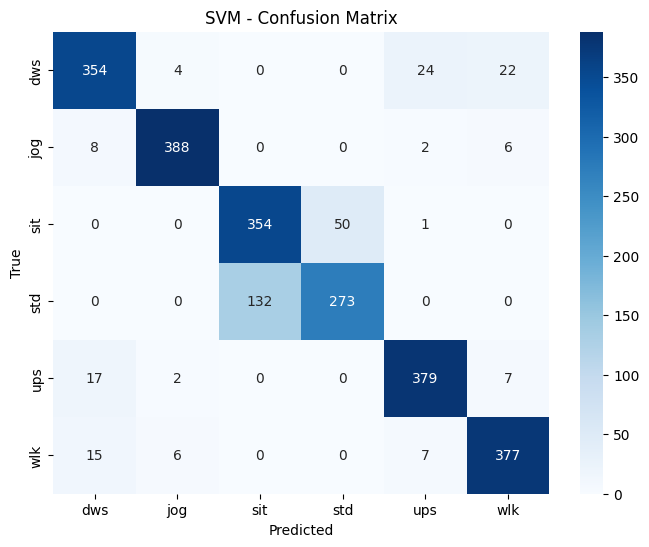

SVM Cross-Validation Scores (5-fold): [0.88220758 0.89085667 0.88014827 0.87227029 0.88998764]
SVM Cross-Validation Mean Accuracy: 0.8830940904391765


In [28]:
# Train SVM with class_weight
svm_model = SVC(kernel='rbf', C=10, gamma=0.01,)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluation
print("=== SVM Classification Report ===")
print(classification_report(y_test, y_pred_svm, target_names=label_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# SVM Cross-Validation (5-fold) 
svm_cv = cross_val_score(
    SVC(kernel='rbf', C=10, gamma=0.01),
    X_ml, y_ml_encoded,
    cv=5,
    scoring='accuracy'
)

# === Output results ===
print("SVM Cross-Validation Scores (5-fold):", svm_cv)
print("SVM Cross-Validation Mean Accuracy:", svm_cv.mean())



### Random Forest

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

         dws       0.94      0.90      0.92       404
         jog       0.98      0.97      0.98       404
         sit       0.98      0.97      0.97       405
         std       0.97      0.98      0.97       405
         ups       0.92      0.95      0.94       405
         wlk       0.94      0.97      0.95       405

    accuracy                           0.96      2428
   macro avg       0.96      0.96      0.96      2428
weighted avg       0.96      0.96      0.96      2428



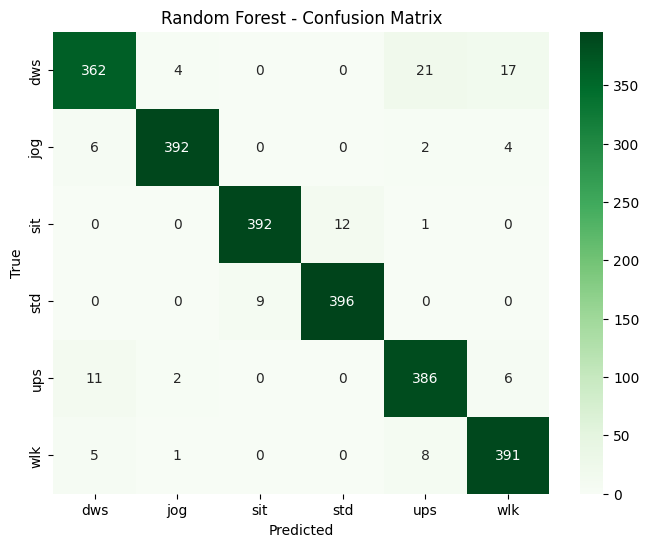

Random Forest Cross-Validation Scores (5-fold): [0.95222405 0.9485173  0.95263591 0.95014421 0.95632468]
Random Forest Cross-Validation Mean Accuracy: 0.9519692313749288


In [29]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluation
print("=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred_rf, target_names=label_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=label_names, yticklabels=label_names)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Random Forest Cross-Validation (5-fold) 
rf_cv = cross_val_score(
    RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    X_ml, y_ml_encoded,
    cv=5,
    scoring='accuracy'
)

# Output results 
print("Random Forest Cross-Validation Scores (5-fold):", rf_cv)
print("Random Forest Cross-Validation Mean Accuracy:", rf_cv.mean())



### AdaBoost

c:\Users\maniq\Downloads\FYP\code\A_DeviceMotion_data\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


=== AdaBoost Classification Report ===
              precision    recall  f1-score   support

         dws       0.93      0.92      0.93       404
         jog       0.99      0.98      0.98       404
         sit       0.98      0.98      0.98       405
         std       0.98      0.98      0.98       405
         ups       0.93      0.97      0.95       405
         wlk       0.98      0.98      0.98       405

    accuracy                           0.96      2428
   macro avg       0.97      0.96      0.97      2428
weighted avg       0.97      0.96      0.97      2428



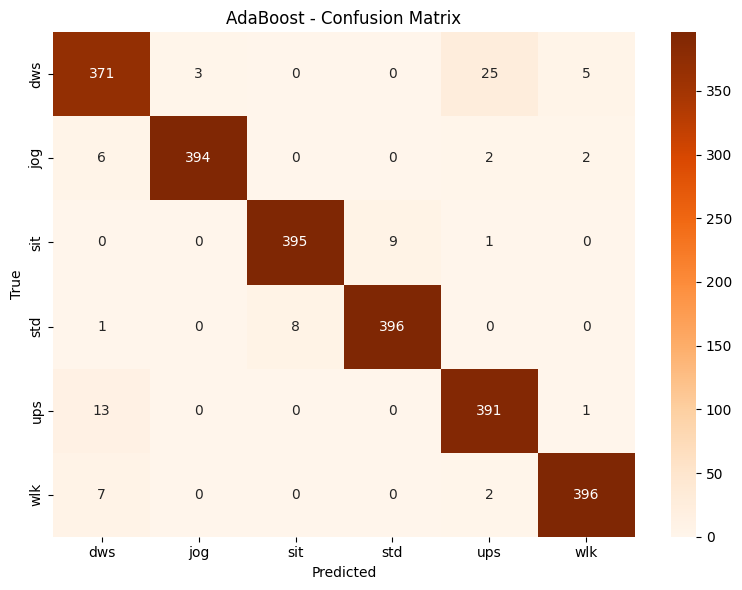

AdaBoost Cross-Validation Scores (5-fold): [0.96004942 0.95963756 0.95757825 0.95962093 0.95797281]
AdaBoost Cross-Validation Mean Accuracy: 0.9589717952007515


In [30]:
# Define Base Estimator
base = DecisionTreeClassifier(max_depth=3, class_weight='balanced')

# AdaBoost Classifier
ada_model = AdaBoostClassifier(
    estimator=base,
    n_estimators=300,
    learning_rate=0.5,
    algorithm='SAMME',
    random_state=42
)

# Train Model
ada_model.fit(X_train_scaled, y_train)

# Predict
y_pred_ada = ada_model.predict(X_test_scaled)

# Evaluation Report
print("=== AdaBoost Classification Report ===")
print(classification_report(y_test, y_pred_ada, target_names=label_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_names, yticklabels=label_names)
plt.title("AdaBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# AdaBoost Cross-Validation (5-fold)
ada_cv = cross_val_score(
    AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
        n_estimators=300,
        learning_rate=0.5,
        algorithm='SAMME',
        random_state=42
    ),
    X_ml, y_ml_encoded,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Output results
print("AdaBoost Cross-Validation Scores (5-fold):", ada_cv)
print("AdaBoost Cross-Validation Mean Accuracy:", ada_cv.mean())


### XGBoost 

=== XGBoost Classification Report ===
              precision    recall  f1-score   support

         dws       0.94      0.91      0.93       404
         jog       0.98      0.97      0.97       404
         sit       0.97      0.97      0.97       405
         std       0.97      0.97      0.97       405
         ups       0.93      0.95      0.94       405
         wlk       0.95      0.97      0.96       405

    accuracy                           0.96      2428
   macro avg       0.96      0.96      0.96      2428
weighted avg       0.96      0.96      0.96      2428



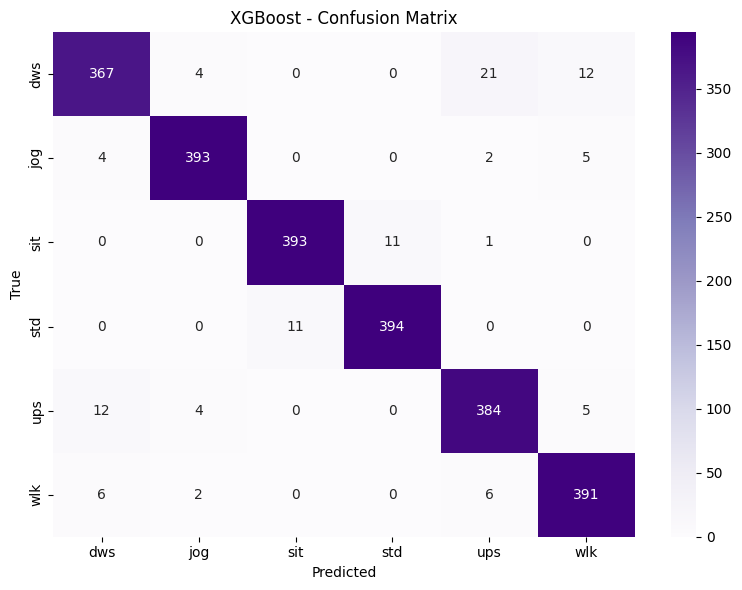

XGBoost Cross-Validation Scores (5-fold): [0.95510708 0.95428336 0.95881384 0.9513803  0.95797281]
XGBoost Cross-Validation Mean Accuracy: 0.9555114788394429


In [31]:
# Train XGBoost Model
xgb_model = XGBClassifier(
    n_estimators=50,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)  
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Classification Report
print("=== XGBoost Classification Report ===")
print(classification_report(y_test, y_pred_xgb, target_names=label_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=label_names, yticklabels=label_names)
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# XGBoost Cross-Validation (5-fold)
xgb_cv = cross_val_score(
    XGBClassifier(
        n_estimators=50,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mlogloss',
        random_state=42
    ),
    X_ml, y_ml_encoded,
    cv=5,
    scoring='accuracy'
)

# Output results
print("XGBoost Cross-Validation Scores (5-fold):", xgb_cv)
print("XGBoost Cross-Validation Mean Accuracy:", xgb_cv.mean())



## Deep Learning Model

### Check Dataset Shape

In [32]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Print shape
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (9710, 72)
y_train shape: (9710,)


### CNN MODEL


In [33]:
from sklearn.preprocessing import LabelEncoder

# Use the same label encoder for both train and test
le_dl = LabelEncoder()

# Fit only on y_train_dl to avoid data leakage
y_train_dl_encoded = le_dl.fit_transform(y_train_dl)

# Transform y_test_dl using the same encoder
y_test_dl_encoded = le_dl.transform(y_test_dl)


# Use readable class names
target_names = ['dws', 'jog', 'sit', 'std', 'ups', 'wlk']


print("✅ y_train_dl_encoded shape:", y_train_dl_encoded.shape)
print("✅ y_test_dl_encoded shape:", y_test_dl_encoded.shape)


✅ y_train_dl_encoded shape: (9710,)
✅ y_test_dl_encoded shape: (2428,)


c:\Users\maniq\Downloads\FYP\code\A_DeviceMotion_data\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.5664 - loss: 1.4799 - val_accuracy: 0.7129 - val_loss: 1.1349
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8206 - loss: 0.4924 - val_accuracy: 0.8694 - val_loss: 0.5409
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8863 - loss: 0.3287 - val_accuracy: 0.9094 - val_loss: 0.3536
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9043 - loss: 0.2559 - val_accuracy: 0.9428 - val_loss: 0.2072
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.9234 - loss: 0.2138 - val_accuracy: 0.9481 - val_loss: 0.1904
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9449 - loss: 0.1497 - val_accuracy: 0.9572 - val_loss: 0.1545
Epoch 7/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9423 - loss: 0.1683 - val_accuracy: 0.9395 - val_loss: 0.2211
Epoch 8/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9532 - loss: 0.1480 - val_acc

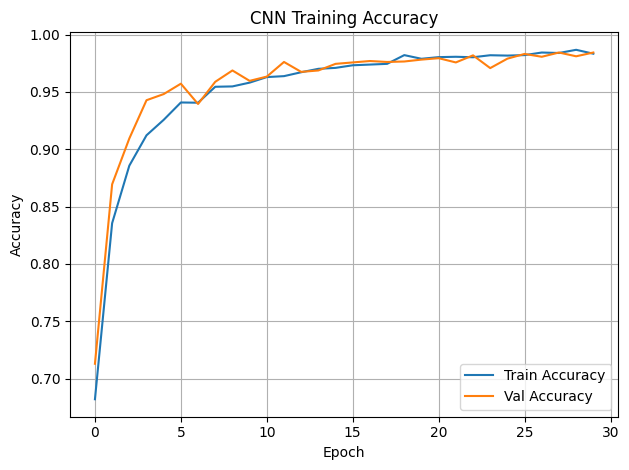

Final Train Accuracy: 0.9833
Final Validation Accuracy: 0.9843


In [34]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#  Define CNN architecture
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(le_dl.classes_), activation='softmax')  # Multi-class
])

# Compile the model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Set early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = cnn_model.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_test_dl, y_test_dl),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

#  Save model
cnn_model.save("cnn_model.h5")

# Plot Training Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("CNN Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print Final Accuracy Values
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Train Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


📊 Classification Report:

              precision    recall  f1-score   support

         dws       0.96      0.98      0.97       404
         jog       0.99      0.99      0.99       404
         sit       1.00      1.00      1.00       405
         std       1.00      1.00      1.00       405
         ups       0.99      0.95      0.97       405
         wlk       0.98      0.99      0.98       405

    accuracy                           0.98      2428
   macro avg       0.98      0.98      0.98      2428
weighted avg       0.98      0.98      0.98      2428



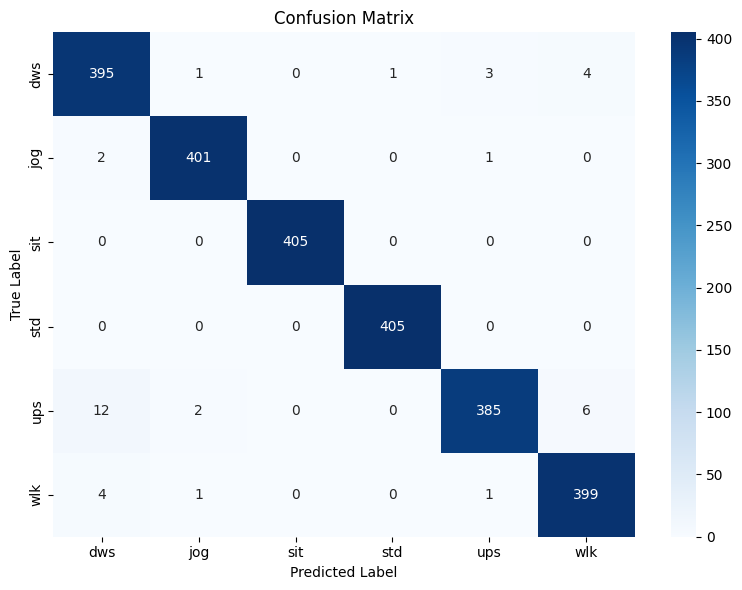

In [35]:
# Predict on test set
y_pred = np.argmax(cnn_model.predict(X_test_dl, verbose=0), axis=1)

# Classification Report
print("📊 Classification Report:\n")
print(classification_report(y_test_dl, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test_dl, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


## LSTM Model

c:\Users\maniq\Downloads\FYP\code\A_DeviceMotion_data\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 31s 298ms/step - accuracy: 0.3185 - loss: 1.6062 - val_accuracy: 0.5980 - val_loss: 1.0726
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 0.5715 - loss: 1.1103 - val_accuracy: 0.6697 - val_loss: 0.8326
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - accuracy: 0.6277 - loss: 0.9330 - val_accuracy: 0.7331 - val_loss: 0.6919
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 25s 324ms/step - accuracy: 0.7003 - loss: 0.8069 - val_accuracy: 0.7257 - val_loss: 0.7718
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - accuracy: 0.7345 - loss: 0.7447 - val_accuracy: 0.8118 - val_loss: 0.5445
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 248ms/step - accuracy: 0.7795 - loss: 0.6790 - val_accuracy: 0.8509 - val_loss: 0.4725
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.8213 - loss: 0.5924 - val_accuracy: 0.8567 - val_loss: 0.4637
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.8371 - loss: 0.5361 - val_accu

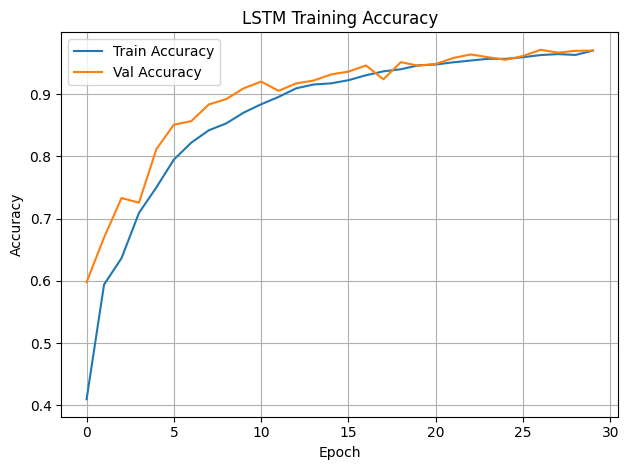

Final Train Accuracy (LSTM): 0.9699
Final Validation Accuracy (LSTM): 0.9699


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Get shape
time_steps = X_train_dl.shape[1]
n_features = X_train_dl.shape[2]
n_classes = len(np.unique(y_train_dl))

# Define model
lstm_model = Sequential([
    LSTM(64, input_shape=(time_steps, n_features), return_sequences=True, recurrent_dropout=0.2),
    Dropout(0.4),
    LSTM(48),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

# Compile
lstm_model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train with real validation set
history = lstm_model.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_test_dl, y_test_dl),
    epochs=30,
    batch_size=128,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("LSTM Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final Accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final Train Accuracy (LSTM): {final_train_acc:.4f}")
print(f"Final Validation Accuracy (LSTM): {final_val_acc:.4f}")


📊 LSTM Classification Report:

              precision    recall  f1-score   support

         dws       0.91      0.97      0.94       404
         jog       0.99      0.97      0.98       404
         sit       1.00      1.00      1.00       405
         std       0.99      1.00      0.99       405
         ups       0.97      0.93      0.95       405
         wlk       0.97      0.97      0.97       405

    accuracy                           0.97      2428
   macro avg       0.97      0.97      0.97      2428
weighted avg       0.97      0.97      0.97      2428



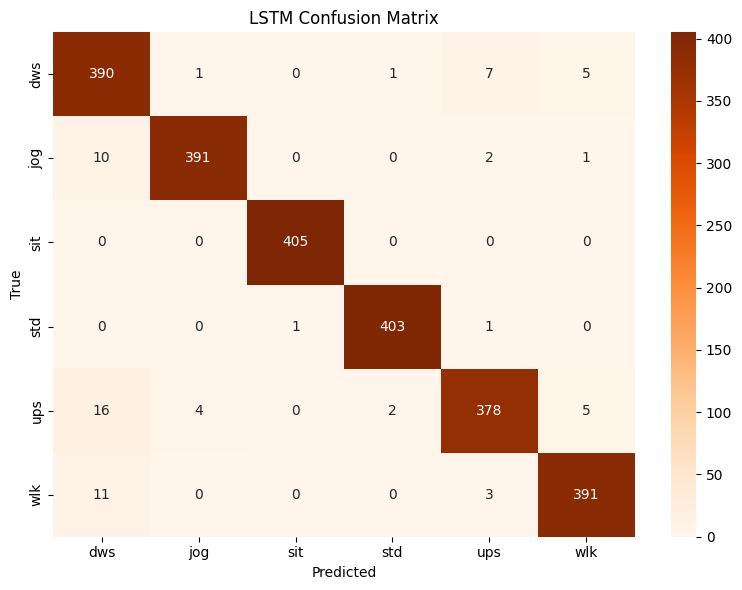

In [37]:
# === 1. Predict with LSTM ===
y_pred_lstm = np.argmax(lstm_model.predict(X_test_dl, verbose=0), axis=1)

print("📊 LSTM Classification Report:\n")
print(classification_report(y_test_dl_encoded, y_pred_lstm, target_names=target_names))

# === 3. Confusion Matrix ===
cm_lstm = confusion_matrix(y_test_dl_encoded, y_pred_lstm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_names, yticklabels=target_names)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


### Compare The Evaluation Among Model

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np

def summarize_model_metrics():
    rows = []

    # Traditional ML models and CV
    ml_models = {
        'SVM': (svm_model, y_pred_svm),
        'Random Forest': (rf_model, y_pred_rf),
        'AdaBoost': (ada_model, y_pred_ada),
        'XGBoost': (xgb_model, y_pred_xgb)
    }

    for name, (model, preds) in ml_models.items():
        acc = accuracy_score(y_test, preds)
        prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds, average='weighted')

        # Cross-validation (5-fold) on training set
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        cv_mean = cv_scores.mean()

        rows.append([name, acc, prec, rec, f1, cv_mean, "-"])

    # Deep Learning Models
    for name, model in [('CNN', cnn_model), ('LSTM', lstm_model)]:
        preds = model.predict(X_test_dl).argmax(axis=1)
        acc = accuracy_score(y_test_dl, preds)
        prec, rec, f1, _ = precision_recall_fscore_support(y_test_dl, preds, average='weighted')

        # Final validation accuracy from model.evaluate
        _, val_acc = model.evaluate(X_test_dl, y_test_dl, verbose=0)

        rows.append([name, acc, prec, rec, f1, "-", val_acc])

    # DataFrame
    df = pd.DataFrame(rows, columns=[
        'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'CV Accuracy (ML only)', 'Val Accuracy (DL only)'
    ])
    df = df.round(4).sort_values(by='Accuracy', ascending=False)
    display(df)

# Call the function
summarize_model_metrics()


c:\Users\maniq\Downloads\FYP\code\A_DeviceMotion_data\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\maniq\Downloads\FYP\code\A_DeviceMotion_data\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\maniq\Downloads\FYP\code\A_DeviceMotion_data\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\maniq\Downloads\FYP\code\A_DeviceMotion_data\.conda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
 

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


,Model,Accuracy,Precision,Recall,F1-Score,CV Accuracy (ML only),Val Accuracy (DL only)
4,CNN,0.9843,0.9845,0.9843,0.9843,-,0.984349
5,LSTM,0.9712,0.9717,0.9712,0.9713,-,0.97117
2,AdaBoost,0.9650,0.9652,0.9650,0.9650,0.96138,-
3,XGBoost,0.9563,0.9564,0.9563,0.9563,0.953347,-
1,Random Forest,0.9551,0.9554,0.9551,0.9550,0.949743,-
0,SVM,0.8752,0.8791,0.8752,0.8744,0.872194,-


### Save File For Streamlit

In [39]:
# Predictions for ML 
y_pred_svm = svm_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_ada = ada_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Save predictions and test sets
np.save("y_test.npy", y_test)
np.save("y_pred_svm.npy", y_pred_svm)
np.save("y_pred_rf.npy", y_pred_rf)
np.save("y_pred_ada.npy", y_pred_ada)
np.save("y_pred_xgb.npy", y_pred_xgb)

np.save("X_test.npy", X_test)             
np.save("X_test_dl.npy", X_test_dl)
np.save("y_test_dl.npy", y_test_dl)

# Save training data for CV 
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)

# Save deep learning models ===
cnn_model.save("cnn_model.h5")
lstm_model.save("lstm_model.h5")


c:\Users\maniq\Downloads\FYP\code\A_DeviceMotion_data\.conda\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\maniq\Downloads\FYP\code\A_DeviceMotion_data\.conda\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\maniq\Downloads\FYP\code\A_DeviceMotion_data\.conda\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
